--- 
Project for the course "Open Source Economics" | Winter term 2021/22, M.Sc./Ph.D. Economics, University of Bonn | [Alexandros Gilch](https://github.com/alexandrosgi)

# Implementation of the course project of the Mitsui Center Summer School 2021  <a class="tocSkip">   
Ross School of Business, University of Michigan  <a class="tocSkip">  
Organizers:  <a class="tocSkip">  
Toni Whited, University of Michigan  <a class="tocSkip">  
Luke Taylor, University o Pennsylvania
---

### Meeting 2021/12/21 2.45 pm

Questions:

- theoretical background enough? Should focus rather on model or estimation method?
- how much explanations additional to code really necessary? Rather focus on code documentation or on interpretation of results?
- Code:
    - Structure: Are classes the right way to go? When, when not?
    - Should we try to use numba? Apparently we would need to go back to for-loops for that
    - What about pandas? We do not use as much data as example project and present less of it. Also we fear performance issues. On the other hand it is nicer to handle and display.
- In general: How much effort should go into this project? FOr us it is more like a toy project to have a base implementation of a structural model and the corresponding estimation, in order to obtain some experience for future research and the possible development of such models.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item">
    <li><span><a href="#1.-Introduction" data-toc-modified-id="1.-Introduction-1">1. Introduction</a></span></li>
    <li><span><a href="#2.-Theoretical-Background" data-toc-modified-id="2.-Theoretical-Background-2">2. Theoretical Background: Structural Estimation</a></span></li>
    <li><span><a href="#3.-Theoretical-Background" data-toc-modified-id="3.-Theoretical-Background-3">3. Theoretical Background: Corporate Finance Workhorse Model</a></span></li>
    <li><span><a href="#4.-Solution" data-toc-modified-id="4.-Solution-4">4. Solving the model</a></span><ul class="toc-item">
        <li><span><a href="#4.1.-Solution" data-toc-modified-id="4.1.-Solution-4.1">4.1. Solution</a></span></li>
        <li><span><a href="#4.2.-Implementation" data-toc-modified-id="4.2.-Implementation-4.2">4.2. Implementation</a></span></li>
    </ul></li>
    <li><span><a href="#5.-Results" data-toc-modified-id="5.-Results-5">5. Results</a></span><ul class="toc-item">
        <li><span><a href="#5.1.-Tests-of-the-Validity-of-the-RD-Approach" data-toc-modified-id="5.1.-Tests-of-the-Validity-of-the-RD-Approach-5.1">5.Value and Policy Functions</a></span></li>
        <li><span><a href="#5.2.-First-Year-GPAs-and-Academic-Probation" data-toc-modified-id="5.2.-First-Year-GPAs-and-Academic-Probation-5.2">5.2. Identification strategy and Estimation</a></span></li>
        <li><span><a href="#5.3.-The-Immediate-Response-to-Academic-Probation" data-toc-modified-id="5.3.-The-Immediate-Response-to-Academic-Probation-5.3">5.3. Comparing Optimizers and Robustness to Noisy Functions</a></span></li>
    </ul></li>
</ul></div>

In [4]:
import numpy as np
from auxiliary.Model import Model
from auxiliary.Sample import Sample
from auxiliary.helpers_plotting import visualize_model_fit
from auxiliary.estimation_func import get_estimation_results, run_noisy_estimation

---
# 1. Introduction <a id="#1.-Introduction"></a>
---

In the following we present the implementation as well as the results of the course project at last years Mitsui Center Summer School at the Ross School of Business, University of Michigan. The main goal of this summer school was to introduce PhD students in the fields of finance and business to some methods from the field of structural estimation and provide them the opportunity to implement these methods on their own for a workhorse model from Corporate Finance.

This notebook is structured as follows: In the next section, we present the basic components necessary for the structural estimation of a generic dynamic model. In section 3, we specify the considered model and shortly describe its context in the corporate finance literature. Section 4 gives a short overview how the implementation is structured. Section 5 covers the major part of the analysis: In section 5.1, we show value and policy functions for a base parametrization of the model, section 5.2 continues with our identification strategy and the estimation of two economic primitives and section 5.3 concludes with a comparison of optimizers and a robustness check against noisy function evaluations.

Disclaimer: this project required a great deal of coding which was our main objective. Unfortunately in this context the description of each single step may have suffered a little. However, we hope that the main steps remain clear to the reader and reference him or her to the file ProjectDescription.pdf (available in this repository under "files") for the detailed instructions which guided us through this project.

---
# 2. Theoretical Background: Structural estimation 
---

As economic researcher we are interested in understanding complex and often dynamic interactions and decisions of economic agents. For that matter, we consider a generic economic model which starts with some assumptions about agents' preferences, their possible choices and constraints, a notion of equilibrium and so on. Based on these components for which we also would like to have real world data, the model makes predictions about the relation of observable, often endogenous variables. 

- Assume we have a economic model --> want to model complex/dynamic interactions/decisions of agents over time
    - agent's preferences
    - (budget) constraints
    - firm's prod function
    - equilibrium, ...
    --> want to make predictions about observable (endogenous) variables
- Structural Estimation (SE)
    - estimate model parameter and assess model fit (using and to real data)
    - in particular not only some correlation parameters, but "real" economic parameters
- SE vs reduced-form (RF) estimation
    - RF: find causal effect X on Y (need correlation and exogeneity)
    - SE: Why does X affect Y?, economic primitives not just some slopes, may construct/examine counterfactuals
- Model for SE should be "realistic", more than 2 states, more than 2 periods
- Popular estimators in SE particularly include Maximum Likelihood and GMM
- May need simulated/approximated versions if no closed-form solution of model exists

In this project, we used a standard Simulated Method of Moments estimator with an optimal weight matrix computed from the observations.


---
# 3. Theoretical Background: Corporate Finance Workhorse Model
---

The following model from corporate finance serves dummy this structural estimation exercise. We will not focus much on the economic interpretation of its result as it is too small in scale and too simple in its construction to fully explain firm behavior under random productivity shocks. However it provides us with all (most of) the main challenges one faces when considering structural estimation of a dynamic model: a variety of parameters to estimate and moments to match and a non-analytical model solution (i.e. the necessity to solve and simulate the model multiple times). Luckily, a data set was already provided.

for the purpose of conciseness, we keep the model description short:

- firm-manager maximizes expected present value of shareholders
- Setup
    - infinite-horizon, discrete-time environment, $t=0,1,2,...$
    - decreasing returns production technology generates income 
    
        $Y=zK^\alpha$, 
    
        where $\alpha<1$ is interpreted as measure for the fixed industry productivity
    - profitability shocks $z$, lognormally distributed with AR(1) process:
    
        $\ln(z')=\rho\ln(z)+\sigma\varepsilon'$, where $\varepsilon'\sim N(0,1)$
        
    - investment $I$ chosen based on standard capital stock accounting identity with depreciation rate $\delta<1$>:
    
        $K'=(1-\delta)K+I$ 

    - firm cash flow 
    
        $E^*(K,K',z)= zK^\alpha-K'+(1-\delta)K$, 
    
    - shareholder cash flow 
    
        $E=E^*$ if $E^*\geq 0$ and 
    
        $E=(1+\gamma)E^*$ if $E^*<0$, i.e. the firm pays a linear cost to issue equity
    - ==> get intertemporal firm maximization problem, given parameters $\alpha, \delta$:

        $\Pi(K,z)=\max_{K'} E(K,K',z)+\beta\mathbf{E}\Pi(K',z')$



---
# 4. Model Solution and Implementation
---

## 4.1 Solution methods
- Model constitutes dynamic programming problem
    - need to discretize shock and capital space
    - apply value and policy function iteration to solve for optimal capital choice given any capital endowment and shock state
    - this needs to be done for every parameter vector $(\alpha, \delta)$ as capital choices are sensible to both parameters and there is no analytical solution
- Want to estimate parameters $\alpha, \delta$ with GMM
    - are interesting economic primitives and might be interesting for other models as well. Could also be compared to results from other papers
    - need to determine moments to match --> natural candidates (as they are also available in the observations): mean and variances of investment rate and profitability
    - model does not have closed form solution --> need to simulate time series to obtain model moments
    - hence have MSM instead of GMM estimator --> this does have an effect on convergence behavior but this will not be the focus of this project
- Data
    - have basic data set with $i=1,...,11169$ firms (identified by id) for $T_i$ time periods (in years) and total number of observations = 114647
    - 2 variables provided: profitability, investment rate
    - ni the terms of our model:

        $profitability = Y/K$
    
        $investment rate = (K'-(1-\delta)K)/K$
    - Provide some summary statistics of data

## 4.2 Implementation
- integrated model setup, solution and simulation in a class object
    - object orientation as a way to better structure the code
    - only certain functions for visualization designated for use from "outside"
    - parallel creation of instances with different parameters possible to compare performances (although not used here, possible extension for later usages)
    - nice to have if high performance (e.g. for high accuracy or high number of simulations) is not main goal
- data usage in separate class object
    - 5 possible (reasonable) moments (generalized notion off moments): mean, var of both plus coefficients of regressing one var on the other one
    - use demeaned data (firm and time fixed effects) 
- estimation not in class object due to time constraints


---
# 5. Results
---

Naturally, during the structural estimation even of a relatively simple model as the presented one there are much more parameters to choose than one could simply estimate or test in the scope of this project. Therefore, we rely firstly on assumptions in the problem formulation, secondly on further assumptions in the implementation of the authors and thirdly on tests we carried out ourselves. We focus on the presentation of the estimators under the given parametrizations and leave it up to the reader to test other configurations. All preset parameters can be found in the following code block.

In [5]:
deep_param = {
    "beta" : 0.96,
    "gamma": 0.05, # corresponds to lambda in project description
    "rho" : 0.75, 
    "sigma" : 0.15
}

discretization_param = {
    "size_shock_grid" : 11, 
    "range_shock_grid" : 2.575
}

approx_param = {
    "max_iter" : 1000, 
    "precision" : 1e-4, 
    "size_capital_grid" : 101, 
}

sim_param = {
    "number_firms" : 100, 
    "number_simulations_per_firm" : 10, 
    "number_years_per_firm" : 10, 
    "burnin" : 200, 
    "seed" : 10082021
}

alpha_default, delta_default = 0.5, 0.05

visualization_param = {
    "alpha grid bounds" : (alpha_default-0.15, alpha_default+0.15), 
    "delta grid bounds" : (delta_default-0.015, delta_default+0.015),
    "fixed alpha" : alpha_default, 
    "fixed delta" : delta_default, 
    "parameter grid size" : 20
}

mom_param = {
    "no_moments" : 3, 
    "no_param" : 2,
    }
    
opt_param = {
    "solver" : "bobyqa",
    # "solver" : "dual_annealing",
    "start_value" : np.array([alpha_default, delta_default]),
    "bounds_optimizer": [[0.001,1], [0.001, 0.3]],
    "bounds_optimizer_bobyqa" : (np.array([0,0]), np.array([1,0.3])),
    "max_iter" : 100,
    "step_size" : np.finfo(float).eps**(1/3),
    "noise_range" : 10**(-np.linspace(1,6,6)),
    "noisy_function_opt" : False}

## 5.1 Value and Policy functions

For a better understanding of the proposed model, we first plot value and policy function with the base parametrization $\alpha=0.5, \delta=0.05$. We observe that for higher productivity the achievable firm value is generally higher since firms are able to produce more efficiently. In particular, we observe that firm value is up to 50\% higher after a high productivity shock compared to a low productivity shock.

Next we plot the different capital choices $K'$ given capital $K$ for all 3 shock regimes. We obtain a choice function which is always characterized by 2 kinks: For each shock size, there minimal and maximal amount of capital which every firm wants to achieve if it has lower or higher capital respectively. This is regardless of how large the difference is. If the firm lies between both values, then capital choice is linear in capital without any kinks.

Economically speaking, no matter how high the current capital, given the high productivity shock, it makes no sense to have more capital next period than the upper bound since more capital will not be more productive than just paying out shareholders this period. On the other side, it always makes sense to achieve at least the lower bound and demand reinvestments from the shareholders. This is equivalent to raising capital of any necessary size from the firms investors (if the firm has less than the minimal capital) or divesting by any size necessary and distributing the capital to the investors

Finally, this results are also apparent in the third plot, which shows equity issuance: If the firm has low capital, then it needs to issue a high amount of equity if the productivity shock is high because the minimal amount of optimal capital lies comparatively high in this scenario. On the other hand, if the productivity shock is small as well, then most capital values are already higher than the minimal optimal capital and almost no equity issuance is necessary.

Below we also show three-dimensional plots which demonstrate the above intuitions hold linearly in the shock size $z$.

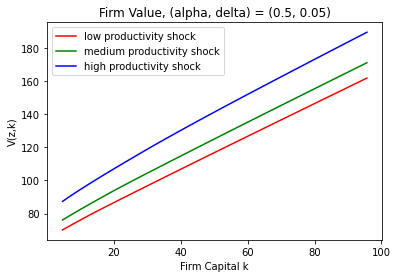

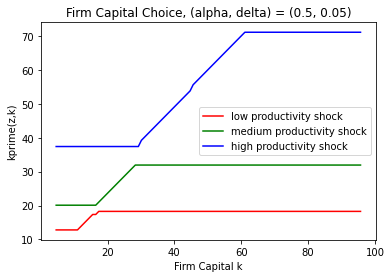

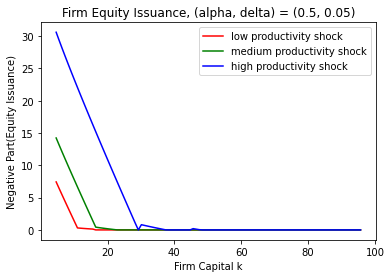

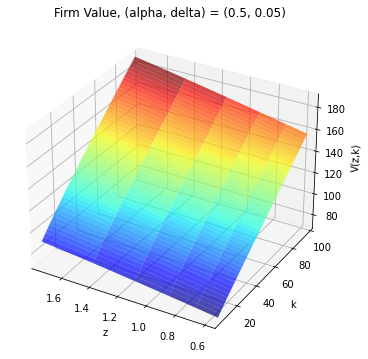

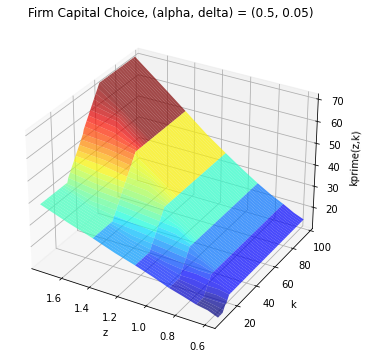

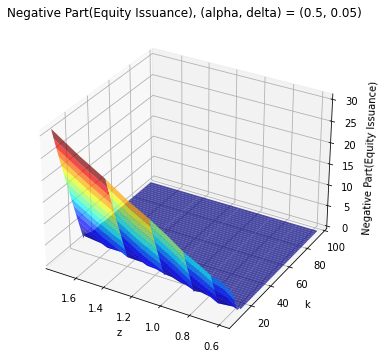

In [6]:
model = Model(deep_param, discretization_param, approx_param)
model.visualize_model_sol(visualization_param)

## 5.2 Identification strategy and Estimation

- Show visualization of sensitivities of moments to changes in $\alpha, \delta$
- Interpretation
    - Certain moments/moment combinations are better suited for GMM than others, since they don't move in the same direction
- 

In the next step, we implemented the simulation of model which will allows at the end of this chapter to estimate the parameters $\alpha$ and $\delta$ for the empirical data. 
First, we 

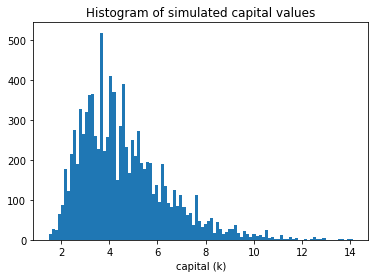

In [7]:
model.visualize_simulated_capital(visualization_param, sim_param)

For given $\delta=0.05$ and $\alpha=0.5$ respectively we plot three simulated moments for multiple values of $\alpha$ and $\delta respectively. The goal of this exercise is to determine a set of two moments which allows for the best approximation of the empirical moments through the simulated moments. For this purpose, we search for moments whose gradients in $(\alpha, \delta)$ are not collinear as this slows down the optimization of the SMM-objective function.

We see in the plots below that the general shape of the curves coincide with our intuition: Given $\delta$ a higher industry productivity $\alpha$ leads to higher mean profitability and mean investment rate but also to more variance in profitability as the size of the individual productivity shock has a higher impact. On the other hand, for given $\alpha$, a higher capital depreciation rate $\delta$ leads to lower profitability as higher share of the profits is required to maintain the productive capital. Similarly the investment rate goes up to account for this effect.

Considering our criterion for a good set of moments, we will choose mean profitability and mean investment rate to match with the empirical values. 

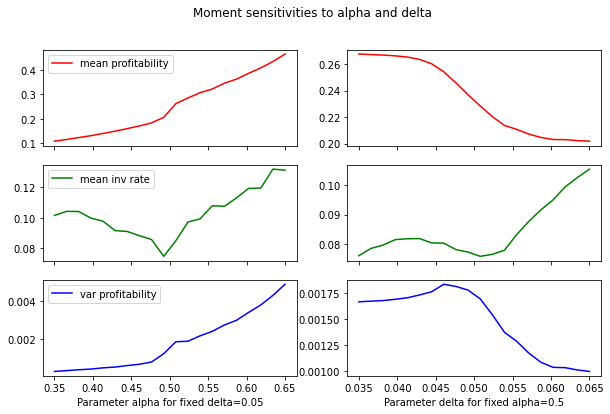

In [8]:
model.visualize_mom_sensitivity(visualization_param, sim_param)

At last, we estimate the estimate $\alpha$ and $\delta$ using one of two implemented optimizers (Dual-annealing from the SciPy package and BOBYQA from the Py-Bobyqa package). BOBYQA proved to be much quicker and reliable for this purpose.

All derivations for the objective function, the weight matrix and the standard errors can be found in the files SUMMER_SCHOOL--GMM.pdf and SUMMER_SCHOOL--SMM--Part1.pdf which are provided in the directory "files" of this repository. For the sake of conciseness, we skip the further illustration of the method at this point.

In [9]:
sample = Sample(mom_param)
estimators, simulated_moments, _, standard_errors = get_estimation_results(sample, model, sim_param, opt_param)
print(f'{estimators=}')
print(f'{simulated_moments=}')
print(f'{standard_errors=}')

estimators=array([0.41654707, 0.03375177])
simulated_moments=array([0.14062207, 0.06913574, 0.00048334])
standard_errors=array([0.0014748 , 0.00142074])


Finally, we simulate the model one more time with the estimated $\alpha$ and $\delta$ and compare our simulated with the targeted moments. Although the variances seem to be a little off, particularly for the investment rate, the mean and median fit quite well (as it should be). Hence, if we were to publish results, we could include variances as further moments to match in order to get a better approximation of simulation to observation. On the other hand of course more moments would also lead to overidentification.

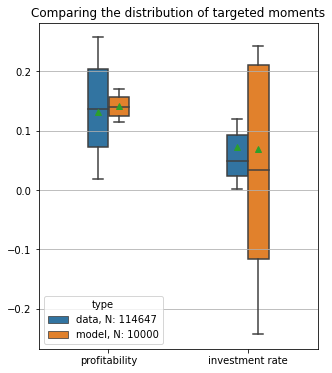

In [10]:
visualize_model_fit(sample, model, estimators[0], estimators[1], sim_param)

## 5.3 Comparing optimizers and robustness to noisy functions

As a last exercise in this project we want to compare both optimizers in an environment that can often be observed in reality: noisy data and hence function evaluations. We model this by multiplying the SMM objective function with $(1+\varepsilon)$ where $\varepsilon\in\{10^{-1},...,10^{-6}}. 

In [11]:
opt_param["noisy_function_opt"] = True
run_noisy_estimation(sample, model, sim_param, opt_param)

In [ ]:

opt_param = {
    # "solver" : "bobyqa",
    "solver" : "dual_annealing",
    "start_value" : np.array([alpha, delta]),
    "bounds_optimizer": [[0.001,1], [0.001, 0.3]],
    "bounds_optimizer_bobyqa" : (np.array([0,0]), np.array([1,0.3])),
    "max_iter" : 1000,
    "step_size" : np.finfo(float).eps**(1/3),
    "noise_range" : 10**(-np.linspace(1,6,6)),
}

In [ ]:

run_noisy_estimation(sample, model, sim_param, opt_param)